**Simple example of transfer learning from pretrained model using PyTorch.**
* Metrics: f1_score

In [34]:
! sudo apt-get install cuda-drivers -y


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  gconf-service gconf-service-backend gconf2 gconf2-common libbonobo2-0
  libbonobo2-common libgconf-2-4 libgnome-2-0 libgnome2-common libgnomevfs2-0
  libgnomevfs2-common libllvm3.8 libmircommon5 liborbit-2-0 libqmi-glib1
  linux-headers-4.4.0-47 linux-headers-4.4.0-47-generic linux-headers-4.4.0-53
  linux-headers-4.4.0-53-generic linux-image-4.4.0-47-generic
  linux-image-4.4.0-53-generic linux-image-extra-4.4.0-47-generic
  linux-image-extra-4.4.0-53-generic snap-confine
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libcuda1-418 nvidia-418 nvidia-418-dev nvidia-opencl-icd-418
The following packages will be REMOVED:
  libcuda1-367 libcuda1-387 nvidia-367 nvidia-367-dev nvidia-387
  nvidia-387-dev nvidia-opencl-icd-361 nvidia-opencl-icd-367
  nvidia-opencl-icd-


A modprobe blacklist file has been created at /etc/modprobe.d to prevent Nouveau from loading. This can be reverted by deleting /etc/modprobe.d/nvidia-graphics-drivers.conf.
A new initrd image has also been created. To revert, please replace /boot/initrd-4.4.0-59-generic with /boot/initrd-$(uname -r)-backup.

*****************************************************************************
*** Reboot your computer and verify that the NVIDIA graphics driver can   ***
*** be loaded.                                                            ***
*****************************************************************************

Adding system user `nvidia-persistenced' (UID 116) ...
sent invalidate(passwd) request, exiting
sent invalidate(group) request, exiting
Adding new group `nvidia-persistenced' (GID 123) ...
sent invalidate(passwd) request, exiting
sent invalidate(group) request, exiting
sent invalidate(group) request, exiting
sent invalidate(group) request, exiting
Adding new user `nvidia-p

In [3]:
! conda install torchvision -c pytorch --y

Solving environment: done

## Package Plan ##

  environment location: /home/ubuntu/anaconda3

  added / updated specs:
    - torchvision


The following NEW packages will be INSTALLED:

  pytorch            pytorch/linux-64::pytorch-1.1.0-py3.7_cuda9.0.176_cudnn7.5.1_0
  torchvision        pytorch/linux-64::torchvision-0.3.0-py37_cu9.0.176_1


Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [36]:
!pip uninstall torch --y

Uninstalling torch-1.0.1:
  Successfully uninstalled torch-1.0.1


In [2]:
!cd cd /tmp; curl -O https://repo.anaconda.com/archive/Anaconda3-2019.03-Linux-x86_64.sh

/bin/sh: 1: cd: can't cd to cd
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  654M  100  654M    0     0   223M      0  0:00:02  0:00:02 --:--:--  223M
^C


In [5]:
!pip install kaggle

    100% |████████████████████████████████| 61kB 32.9MB/s ta 0:00:01
    100% |████████████████████████████████| 81kB 36.6MB/s ta 0:00:01
  Stored in directory: /home/ubuntu/.cache/pip/wheels/87/ea/09/173986e395d051411b9d547a69fe96cdc26208cb1bcc3e5567
  Stored in directory: /home/ubuntu/.cache/pip/wheels/16/7f/c3/6b0582283ad589d68a306da924a78c74546e010d8106b9b3a9
Successfully built kaggle python-slugify


In [3]:
!pip install opencv-python



    100% |████████████████████████████████| 26.6MB 2.8MB/s eta 0:00:01


In [8]:
!conda install -c pytorch torchvision --yes 


Solving environment: done

## Package Plan ##

  environment location: /home/ubuntu/anaconda3

  added / updated specs:
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.6.14               |           py37_0         2.1 MB
    cudatoolkit-10.0.130       |                0       380.0 MB
    ninja-1.9.0                |   py37hfd86e86_0         1.6 MB
    pytorch-1.1.0              |py3.7_cuda10.0.130_cudnn7.5.1_0       455.0 MB  pytorch
    torchvision-0.3.0          |py37_cu10.0.130_1         3.7 MB  pytorch
    ------------------------------------------------------------
                                           Total:       842.4 MB

The following NEW packages will be INSTALLED:

  cudatoolkit        pkgs/main/linux-64::cudatoolkit-10.0.130-0
  ninja              pkgs/main/linux-64::ninja-1.9.0-py37hfd86e86_0
  pytorch            pytorch/linux-64::pytorch-1.

In [5]:
!pip install torch==1.0.1 -f https://download.pytorch.org/whl/cu80/stable

Looking in links: https://download.pytorch.org/whl/cu80/stable
  Using cached https://files.pythonhosted.org/packages/4e/ba/d78f35357995297206790fe1af8688bc0403828c90f8e99190035196d56e/torch-1.0.1-cp37-cp37m-manylinux1_x86_64.whl


In [56]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import cv2
import torch
from tqdm import tqdm_notebook
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from sklearn.model_selection import train_test_split
from torchvision import transforms

%matplotlib inline

In [57]:
! cd /; cd data; ls

lost+found		   test.csv	 test_images.zip  train_images
sample_submission.csv	   test.csv.zip  train.csv	  train_images.zip
sample_submission.csv.zip  test_images	 train.csv.zip


In [58]:
def kaggle_commit_logger(str_to_log, need_print = True):
    if need_print:
        print(str_to_log)
    os.system('echo ' + str_to_log)

In [59]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [60]:
train_df_all = pd.read_csv('/data/train.csv',engine='python',)
train_df_all.head()

,category_id,date_captured,file_name,frame_num,id,location,rights_holder,seq_id,seq_num_frames,width,height
0,19,2011-05-13 23:43:18,5998cfa4-23d2-11e8-a6a3-ec086b02610b.jpg,1,5998cfa4-23d2-11e8-a6a3-ec086b02610b,33,Justin Brown,6f084ccc-5567-11e8-bc84-dca9047ef277,3,1024,747
1,19,2012-03-17 03:48:44,588a679f-23d2-11e8-a6a3-ec086b02610b.jpg,2,588a679f-23d2-11e8-a6a3-ec086b02610b,115,Justin Brown,6f12067d-5567-11e8-b3c0-dca9047ef277,3,1024,747
2,0,2014-05-11 11:56:46,59279ce3-23d2-11e8-a6a3-ec086b02610b.jpg,1,59279ce3-23d2-11e8-a6a3-ec086b02610b,96,Erin Boydston,6faa92d1-5567-11e8-b1ae-dca9047ef277,1,1024,747
3,0,2013-10-06 02:00:00,5a2af4ab-23d2-11e8-a6a3-ec086b02610b.jpg,1,5a2af4ab-23d2-11e8-a6a3-ec086b02610b,57,Erin Boydston,6f7d4702-5567-11e8-9e03-dca9047ef277,1,1024,747
4,0,2011-07-12 13:11:16,599fbd89-23d2-11e8-a6a3-ec086b02610b.jpg,3,599fbd89-23d2-11e8-a6a3-ec086b02610b,46,Justin Brown,6f1728a1-5567-11e8-9be7-dca9047ef277,3,1024,747


In [61]:
batch_size = 64
IMG_SIZE = 64
N_EPOCHS = 15
ID_COLNAME = 'file_name'
ANSWER_COLNAME = 'category_id'
TRAIN_IMGS_DIR = '/data/train_images/'
TEST_IMGS_DIR = '/data/test_images/'

In [62]:
train_df, test_df = train_test_split(train_df_all[[ID_COLNAME, ANSWER_COLNAME]],
                                     test_size = 0.15,                                     
                                     shuffle = True
                                    )

In [63]:
train_df.head(10)

,file_name,category_id
49489,58995a6f-23d2-11e8-a6a3-ec086b02610b.jpg,0
26272,59373297-23d2-11e8-a6a3-ec086b02610b.jpg,0
841,5a2e12d8-23d2-11e8-a6a3-ec086b02610b.jpg,0
39707,5892b3ca-23d2-11e8-a6a3-ec086b02610b.jpg,0
177608,5a2e14a1-23d2-11e8-a6a3-ec086b02610b.jpg,19
48844,58e40ec2-23d2-11e8-a6a3-ec086b02610b.jpg,3
143147,59da8b75-23d2-11e8-a6a3-ec086b02610b.jpg,19
33424,597fef49-23d2-11e8-a6a3-ec086b02610b.jpg,0
153633,58f73fbb-23d2-11e8-a6a3-ec086b02610b.jpg,0
61932,5a2637ee-23d2-11e8-a6a3-ec086b02610b.jpg,4


In [64]:
CLASSES_TO_USE = train_df_all['category_id'].unique()

In [65]:
CLASSES_TO_USE

array([19,  0,  3,  8,  4, 13,  1, 11, 16, 17, 14, 18, 10, 22])

In [66]:
NUM_CLASSES = len(CLASSES_TO_USE)
NUM_CLASSES

14

In [67]:
CLASSMAP = dict(
    [(i, j) for i, j
     in zip(CLASSES_TO_USE, range(NUM_CLASSES))
    ]
)
CLASSMAP

{19: 0,
 0: 1,
 3: 2,
 8: 3,
 4: 4,
 13: 5,
 1: 6,
 11: 7,
 16: 8,
 17: 9,
 14: 10,
 18: 11,
 10: 12,
 22: 13}

In [68]:
REVERSE_CLASSMAP = dict([(v, k) for k, v in CLASSMAP.items()])
REVERSE_CLASSMAP

{0: 19,
 1: 0,
 2: 3,
 3: 8,
 4: 4,
 5: 13,
 6: 1,
 7: 11,
 8: 16,
 9: 17,
 10: 14,
 11: 18,
 12: 10,
 13: 22}

In [69]:
feature_extract = False
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [70]:
model = models.resnet50(pretrained='imagenet')
#model = models.densenet121(pretrained='imagenet')
set_parameter_requires_grad(model, feature_extract)


In [71]:
model.fc.in_features,model.fc.out_features

(2048, 1000)

In [72]:
model.fc.out_features

1000

In [73]:
model = model.to(device)

In [74]:
new_head = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)
model.fc = new_head


In [75]:
normalizer = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_augmentation = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    normalizer,
])

val_augmentation = transforms.Compose([
    #transforms.CenterCrop(IMG_SIZE),

    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    normalizer,
])

In [76]:
class IMetDataset(Dataset):
    
    def __init__(self,
                 df,
                 images_dir,
                 n_classes = NUM_CLASSES,
                 id_colname = ID_COLNAME,
                 answer_colname = ANSWER_COLNAME,
                 label_dict = CLASSMAP,
                 transforms = None
                ):
        self.df = df
        self.images_dir = images_dir
        self.n_classes = n_classes
        self.id_colname = id_colname
        self.answer_colname = answer_colname
        self.label_dict = label_dict
        self.transforms = transforms
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        cur_idx_row = self.df.iloc[idx]
        img_id = cur_idx_row[self.id_colname]
        img_name = img_id # + self.img_ext
        img_path = os.path.join(self.images_dir, img_name)
        
        img = cv2.imread(img_path)
        #print('HERE ', img_path)
#         print(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img)
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        if self.answer_colname is not None:              
            label = torch.zeros((self.n_classes,), dtype=torch.float32)
            label[self.label_dict[cur_idx_row[self.answer_colname]]] = 1.0

            return img, label
        
        else:
            return img, img_id

In [77]:
train_dataset = IMetDataset(train_df, TRAIN_IMGS_DIR, transforms = train_augmentation)
test_dataset = IMetDataset(test_df, TRAIN_IMGS_DIR, transforms = val_augmentation)

In [78]:
BS = 24

train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=False, num_workers=4, pin_memory=True)

In [79]:
def cuda(x):
    #return x
    return x.cuda(non_blocking=True)

In [80]:
import torch
def F_score(logit, label, threshold=0.5, beta=2):
    prob = torch.sigmoid(logit)
    prob = prob > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob)& (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [81]:
def f1_score(y_true, y_pred, threshold=0.5):
    return fbeta_score(y_true, y_pred, 1, threshold)


def fbeta_score(y_true, y_pred, beta, threshold, eps=1e-9):
    beta2 = beta**2

    y_pred = torch.ge(y_pred.float(), threshold).float()
    y_true = y_true.float()

    true_positive = (y_pred * y_true).sum(dim=1)
    precision = true_positive.div(y_pred.sum(dim=1).add(eps))
    recall = true_positive.div(y_true.sum(dim=1).add(eps))

    return torch.mean(
        (precision*recall).
        div(precision.mul(beta2) + recall + eps).
        mul(1 + beta2))

In [82]:
def train_one_epoch(model, train_loader, criterion, optimizer, steps_upd_logging = 250):
    model.train();
    model = model.to(device)
    
    total_loss = 0.0
    
    train_tqdm = tqdm_notebook(train_loader)
    
    for step, (features, targets) in enumerate(train_tqdm):
#        features, targets = cuda(features), cuda(targets)
        features, targets = features.to(device), targets.to(device) 
        
        optimizer.zero_grad()
        
        logits = model(features)
        
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if (step + 1) % steps_upd_logging == 0:
            logstr = "Train loss on step "+ str(step + 1)+' was '+str(round(total_loss / (step + 1), 5))
            #logstr = f"Train loss on step {step + 1} was {round(total_loss / (step + 1), 5)}"
            train_tqdm.set_description(logstr)
            kaggle_commit_logger(logstr, need_print=False)
        
    return total_loss / (step + 1)

In [83]:
def validate(model, valid_loader, criterion, need_tqdm = False):
    model.eval();
    model = model.to(device)
    test_loss = 0.0
    TH_TO_ACC = 0.5
    
    true_ans_list = []
    preds_cat = []
    
    with torch.no_grad():
        
        if need_tqdm:
            valid_iterator = tqdm_notebook(valid_loader)
        else:
            valid_iterator = valid_loader
        
        for step, (features, targets) in enumerate(valid_iterator):
            #features, targets = cuda(features), cuda(targets)
            features, targets = features.to(device), targets.to(device) 
            logits = model(features)
            loss = criterion(logits, targets)

            test_loss += loss.item()
            true_ans_list.append(targets)
            preds_cat.append(torch.sigmoid(logits))

        all_true_ans = torch.cat(true_ans_list)
        all_preds = torch.cat(preds_cat)
                
        f1_eval = f1_score(all_true_ans, all_preds).item()

    logstr = 'Mean val f1: '+str(round(f1_eval, 5))
    kaggle_commit_logger(logstr)
    return test_loss / (step + 1), f1_eval

In [85]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
sheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10)

In [86]:
TRAIN_LOGGING_EACH = 500

train_losses = []
valid_losses = []
valid_f1s = []
best_model_f1 = 0.0
best_model = None
best_model_ep = 0

for epoch in range(1, N_EPOCHS + 1):
    ep_logstr = "Starting "+str(epoch)+" epoch..."
    kaggle_commit_logger(ep_logstr)
    tr_loss = train_one_epoch(model, train_loader, criterion, optimizer, TRAIN_LOGGING_EACH)
    train_losses.append(tr_loss)
    tr_loss_logstr = 'Mean train loss: '+str(round(tr_loss,5))
    kaggle_commit_logger(tr_loss_logstr)
    
    valid_loss, valid_f1 = validate(model, test_loader, criterion)  
    valid_losses.append(valid_loss)    
    valid_f1s.append(valid_f1)       
    val_loss_logstr = 'Mean valid loss: '+str(round(valid_loss,5))
    kaggle_commit_logger(val_loss_logstr)
    sheduler.step(valid_loss)
    
    if valid_f1 >= best_model_f1:    
        best_model = model        
        best_model_f1 = valid_f1        
        best_model_ep = epoch

Starting 1 epoch...



Mean train loss: 0.11177
Mean val f1: 0.62861
Mean valid loss: 0.09294
Starting 2 epoch...



Mean train loss: 0.09693
Mean val f1: 0.64614
Mean valid loss: 0.08184
Starting 3 epoch...



Mean train loss: 0.0903
Mean val f1: 0.6506
Mean valid loss: 0.07649
Starting 4 epoch...



Mean train loss: 0.08555
Mean val f1: 0.69413
Mean valid loss: 0.07181
Starting 5 epoch...



Mean train loss: 0.08228
Mean val f1: 0.70627
Mean valid loss: 0.0732
Starting 6 epoch...



Mean train loss: 0.07976
Mean val f1: 0.72389
Mean valid loss: 0.06744
Starting 7 epoch...



Mean train loss: 0.07752
Mean val f1: 0.70721
Mean valid loss: 0.06768
Starting 8 epoch...



Mean train loss: 0.07567
Mean val f1: 0.72894
Mean valid loss: 0.06402
Starting 9 epoch...



Mean train loss: 0.07423
Mean val f1: 0.73509
Mean valid loss: 0.06238
Starting 10 epoch...



Mean train loss: 0.07271
Mean val f1: 0.72027
Mean valid loss: 0.07191
Starting 11 epoch...



Mean train loss: 0.0716
Mean val f1: 0.74774
Mean valid loss: 0.06269
Starting 12 epoch...



Mean train loss: 0.07051
Mean val f1: 0.72224
Mean valid loss: 0.08041
Starting 13 epoch...



Mean train loss: 0.06942
Mean val f1: 0.7257
Mean valid loss: 0.08694
Starting 14 epoch...



Mean train loss: 0.0685
Mean val f1: 0.76174
Mean valid loss: 0.05824
Starting 15 epoch...



Mean train loss: 0.06775
Mean val f1: 0.76536
Mean valid loss: 0.0568


In [87]:
bestmodel_logstr = f'Best f1 is {round(best_model_f1, 5)} on epoch {best_model_ep}'
kaggle_commit_logger(bestmodel_logstr)

Best f1 is 0.76536 on epoch 15


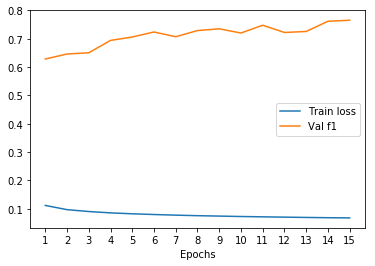

In [88]:
xs = list(range(1, len(train_losses) + 1))

plt.plot(xs, train_losses, label = 'Train loss');
# plt.plot(xs, valid_losses, label = 'Val loss');
plt.plot(xs, valid_f1s, label = 'Val f1');
plt.legend();
plt.xticks(xs);
plt.xlabel('Epochs');

In [89]:
SAMPLE_SUBMISSION_DF = pd.read_csv('/data/sample_submission.csv',engine='python')
SAMPLE_SUBMISSION_DF.head()

,Id,Predicted
0,b005e5b2-2c0b-11e9-bcad-06f10d5896c4,0
1,f2347cfe-2c11-11e9-bcad-06f10d5896c4,0
2,27cf8d26-2c0e-11e9-bcad-06f10d5896c4,0
3,f82f52c7-2c1d-11e9-bcad-06f10d5896c4,0
4,e133f50d-2c1c-11e9-bcad-06f10d5896c4,0


In [90]:
SAMPLE_SUBMISSION_DF.rename(columns={'Id':'file_name','Predicted':'category_id'}, inplace=True)
SAMPLE_SUBMISSION_DF['file_name'] = SAMPLE_SUBMISSION_DF['file_name'] + '.jpg'
SAMPLE_SUBMISSION_DF.head()

,file_name,category_id
0,b005e5b2-2c0b-11e9-bcad-06f10d5896c4.jpg,0
1,f2347cfe-2c11-11e9-bcad-06f10d5896c4.jpg,0
2,27cf8d26-2c0e-11e9-bcad-06f10d5896c4.jpg,0
3,f82f52c7-2c1d-11e9-bcad-06f10d5896c4.jpg,0
4,e133f50d-2c1c-11e9-bcad-06f10d5896c4.jpg,0


In [91]:
subm_dataset = IMetDataset(SAMPLE_SUBMISSION_DF,
                           TEST_IMGS_DIR,
                           transforms = val_augmentation,
                           answer_colname=None
                          )

In [92]:
SUMB_BS = 48

subm_dataloader = DataLoader(subm_dataset,
                             batch_size=SUMB_BS, num_workers=4,
                             shuffle=False,
                             pin_memory=True)

In [93]:
def get_subm_answers(model, subm_dataloader, need_tqdm = False):
    model.eval();
    preds_cat = []
    ids = []
    
    with torch.no_grad():
        
        if need_tqdm:
            subm_iterator = tqdm_notebook(subm_dataloader)
        else:
            subm_iterator = subm_dataloader
        
        for step, (features, subm_ids) in enumerate(subm_iterator):
            features = cuda(features)

            logits = model(features)
            preds_cat.append(torch.sigmoid(logits))
            ids += subm_ids

        all_preds = torch.cat(preds_cat)
        all_preds = torch.argmax(all_preds, dim=1).int().cpu().numpy()
    return all_preds, ids

In [94]:

best_model.cuda();

subm_preds, submids = get_subm_answers(best_model, subm_dataloader, True)

In [95]:
len(subm_preds)

153730

In [96]:
ans_dict = dict(zip(submids, subm_preds.astype(str)))

In [97]:
df_to_process = (
    pd.DataFrame
    .from_dict(ans_dict, orient='index', columns=['Predicted'])
    .reset_index()
    .rename({'index':'Id'}, axis=1)    
)
df_to_process['Id'] = df_to_process['Id'].map(lambda x: str(x)[:-4])
df_to_process.head()

,Id,Predicted
0,b005e5b2-2c0b-11e9-bcad-06f10d5896c4,1
1,f2347cfe-2c11-11e9-bcad-06f10d5896c4,6
2,27cf8d26-2c0e-11e9-bcad-06f10d5896c4,1
3,f82f52c7-2c1d-11e9-bcad-06f10d5896c4,1
4,e133f50d-2c1c-11e9-bcad-06f10d5896c4,1


In [98]:
def process_one_id(id_classes_str):
    if id_classes_str:
        return REVERSE_CLASSMAP[int(id_classes_str)]
    else:
        return id_classes_str

In [99]:
df_to_process['Predicted'] = df_to_process['Predicted'].apply(process_one_id)
df_to_process.head()

,Id,Predicted
0,b005e5b2-2c0b-11e9-bcad-06f10d5896c4,0
1,f2347cfe-2c11-11e9-bcad-06f10d5896c4,1
2,27cf8d26-2c0e-11e9-bcad-06f10d5896c4,0
3,f82f52c7-2c1d-11e9-bcad-06f10d5896c4,0
4,e133f50d-2c1c-11e9-bcad-06f10d5896c4,0


In [100]:
df_to_process.to_csv('submission.csv', index=False)

--- from torchvision

In [35]:
import time
import copy

In [73]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
              
              #  running_corrects += torch.sum(preds == labels.data)
                running_corrects+=1
            if phase == 'val':
                sheduler.step(loss)
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [74]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [75]:
feature_extract = False

In [76]:
model_ft = models.resnet50(pretrained=True)
set_parameter_requires_grad(model_ft, feature_extract)
num_ftrs = model_ft.fc.in_features
model_ft.fc = torch.nn.Linear(num_ftrs, NUM_CLASSES)
#input_size = 224

In [77]:
# Send the model to GPU
model_ft = model_ft.to('cuda')

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight

In [78]:
dataloaders_dict = {}
dataloaders_dict['train'] = train_loader
dataloaders_dict['test'] = test_loader



In [80]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
sheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)
# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer, num_epochs=N_EPOCHS, is_inception=False)


Epoch 0/14
----------


KeyboardInterrupt: 